In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:1")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(1))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    

There are 4 GPU(s) available.
We will use the GPU: TITAN X (Pascal)


In [4]:
# !pip install transformers

In [5]:
# Hyper parameters values

# Set the maximum sequence length.
MAX_LEN = 512

# Set the batch size.  
batch_size = 16 

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

In [2]:
import pandas as pd

print('Parsing the dataset.tsv file ....')
# comments = pd.read_csv('./data/attack_annotated_comments.tsv', sep = '\t', index_col = 0)
train = pd.read_csv('./data/balanced_data/train.tsv', sep = '\t')
test = pd.read_csv('./data/balanced_data/test.tsv', sep = '\t')

print('     DONE.')
print('---------------------')
print('checking for duplicates')
print('number of duplicate values between test and train is:', 
len(set(train['story_id'].unique()) & set(test['story_id'].unique()))
      )

Parsing the dataset.tsv file ....
     DONE.
---------------------
checking for duplicates
number of duplicate values between test and train is: 184


In [117]:
test.groupby('label').size()

label
0    1036
1    1062
dtype: int64

In [3]:
def get_len(text):
    return len(text.split())

# Get the length of raw text
train['len'] = train['raw_text'].apply(get_len)

# Display the first five rows of the table
train.head()

,story_id,raw_text,label,len
0,6772845,"kiev, january 21 (ria novosti) - former ukrain...",1,160
1,35455458,the ukrainian government has called for local ...,0,56
2,38817309,investigators probing the shooting down of mal...,0,343
3,7765503,"kharkov, april 21 (ria novosti) - russia and u...",1,227
4,34816385,"moscow, june 27 (ria novosti) - osce monitors ...",1,250


In [4]:
def get_split(text1):
    split_size = 200
    overlap_size = 50
    v1 = split_size - overlap_size
    l_total = []
    l_parcial = []
    if len(text1.split())//v1 >0:
        n = len(text1.split())//v1
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:split_size]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*v1:w*v1 + split_size]
            l_total.append(" ".join(l_parcial))
    return l_total

In [5]:
train['text_split'] = train['raw_text'].apply(get_split)
train.head()

,story_id,raw_text,label,len,text_split
0,6772845,"kiev, january 21 (ria novosti) - former ukrain...",1,160,"[kiev, january 21 (ria novosti) - former ukrai..."
1,35455458,the ukrainian government has called for local ...,0,56,[the ukrainian government has called for local...
2,38817309,investigators probing the shooting down of mal...,0,343,[investigators probing the shooting down of ma...
3,7765503,"kharkov, april 21 (ria novosti) - russia and u...",1,227,"[kharkov, april 21 (ria novosti) - russia and ..."
4,34816385,"moscow, june 27 (ria novosti) - osce monitors ...",1,250,"[moscow, june 27 (ria novosti) - osce monitors..."


In [6]:
# create a row split version of dataset 

from tqdm import tqdm_notebook as tqdm
tmp = []

for i in tqdm(range(len(train))):
    for j in range(len(train.iloc[i].text_split)):
#         chunk_num = str(train.iloc[i]['story_id']) + '_' + str(j)
        chunk_num = j
        tmp.append(
        {'story_id': train.iloc[i]['story_id'],
            'chunk_num': chunk_num,
            'raw_text': train.iloc[i]['raw_text'],
            'text_chunk': train.iloc[i]['text_split'][j],
            'label': train.iloc[i].label}
        )

train_split_v = pd.DataFrame(tmp) 
# train.head()
print('length of train_split_v is:', len(train_split_v))
train_split_v.head()



length of train_split_v is: 19057


,story_id,chunk_num,raw_text,text_chunk,label
0,6772845,0,"kiev, january 21 (ria novosti) - former ukrain...","kiev, january 21 (ria novosti) - former ukrain...",1
1,35455458,0,the ukrainian government has called for local ...,the ukrainian government has called for local ...,0
2,38817309,0,investigators probing the shooting down of mal...,investigators probing the shooting down of mal...,0
3,38817309,1,investigators probing the shooting down of mal...,at ukraine's military. members of the joint in...,0
4,7765503,0,"kharkov, april 21 (ria novosti) - russia and u...","kharkov, april 21 (ria novosti) - russia and u...",1


In [7]:
print('length of train_split_v is:', len(train_split_v))

length of train_split_v is: 19057


In [9]:
# import textwrap
# import random 

# # wrap text to 80 characters.

# wrapper = textwrap.TextWrapper(width = 100)

# # filter to just "attack" comments.

# examples = train.query('label')['raw_text']

# # Randomly choose some examples

# for i in range(10):
#     j = random.choice(examples.index)
    
#     print('')
#     print(wrapper.fill(examples[j]))
#     print('')

In [8]:
from transformers import BertTokenizer

# load the BERT tokenizer, 
print('loading BERT tokenizer....')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
print('    DONE.')

loading BERT tokenizer....
    DONE.


In [11]:
# # Retrieve the text from the first comment.
# text = train.iloc[10].raw_text

# tokens = tokenizer.tokenize(text)

# # Print the original text
# print('comment 0 (not an attack) contains {:,} wordpiece tokens.'.format(len(tokens)))
# print('\nOriginal comment text:\n')
# print(wrapper.fill(text))


# # print out the list of tokens
# print('**** First 512 tokens:*****\n')
# print(wrapper.fill(str(' '.join(tokens[0:512]))))

# print('')

# print('\n****** Remaining {:,} tokens: *****\n'.format(len(tokens) - 512))
# print(wrapper.fill(str(' '.join(tokens[512:]))))

In [12]:
# # First truncate the text to remove the last 79 tokens (which begin with the words "are made in"). 
# last_char = text.find('are made in')

# # Truncate the text to only what fits in the 512 tokens.
# text = text[0:last_char]

# # Estimate the number of words in the comment by spliting it on whitespace.
# # first remove all double spaces.
# text = text.replace('  ', ' ')
# num_words = len(text.split(' '))
# print('Comment contains ~{:,} words.'.format(num_words))

# # Estimate the number of sentences by counting up the periods.
# num_sens = text.count('. ')
# print('Comment contains ~{:,} sentences.'.format(num_sens))

In [9]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

# Tokenize all the sentences and map the tokens to their word IDs.

input_ids = []

# Record the length of each sequence (after truncating to 512).

lengths = []

print('Tokenizing texts.....')

# For every sentence....
for text in tqdm(train_split_v.text_chunk):
    # Report progress.
    if ((len(input_ids) % 200) == 0):
        print(' Read {:,} texts.'.format(len(input_ids)))
        
    # endoce will: 
    # (1) Tokenize the sentence
    # (2) Prepend the "[CLS]" token to the start.
    # (3) Append the "[SEP]" token to the end.
    # (4) Map tokens to their IDs. 
    encoded_text = tokenizer.encode(
        text,                          #sentence to encode.
        add_special_tokens = True,   # Add '[CLS]' and '[SEP]'
#             max_length = 512,            # Truncate all the sentences.
#             return_tensors = 'pt'        # Return pytorch tensors.
    )
    # Add the encoded sentence to the list
    input_ids.append(encoded_text)
    
    # Record the truncated length.
    lengths.append(len(encoded_text))
    
print('DONE')
print('{:>10,} comments'.format(len(input_ids)))

print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

Tokenizing texts.....


 Read 0 texts.
 Read 200 texts.
 Read 400 texts.
 Read 600 texts.
 Read 800 texts.
 Read 1,000 texts.
 Read 1,200 texts.
 Read 1,400 texts.
 Read 1,600 texts.
 Read 1,800 texts.
 Read 2,000 texts.
 Read 2,200 texts.
 Read 2,400 texts.
 Read 2,600 texts.
 Read 2,800 texts.
 Read 3,000 texts.
 Read 3,200 texts.
 Read 3,400 texts.
 Read 3,600 texts.
 Read 3,800 texts.
 Read 4,000 texts.
 Read 4,200 texts.
 Read 4,400 texts.
 Read 4,600 texts.
 Read 4,800 texts.
 Read 5,000 texts.
 Read 5,200 texts.
 Read 5,400 texts.
 Read 5,600 texts.
 Read 5,800 texts.
 Read 6,000 texts.
 Read 6,200 texts.
 Read 6,400 texts.
 Read 6,600 texts.
 Read 6,800 texts.
 Read 7,000 texts.
 Read 7,200 texts.
 Read 7,400 texts.
 Read 7,600 texts.
 Read 7,800 texts.
 Read 8,000 texts.
 Read 8,200 texts.
 Read 8,400 texts.
 Read 8,600 texts.
 Read 8,800 texts.
 Read 9,000 texts.
 Read 9,200 texts.
 Read 9,400 texts.
 Read 9,600 texts.
 Read 9,800 texts.
 Read 10,000 texts.
 Read 10,200 texts.
 Read 10,400 texts.
 R

In [10]:
chunk_nums = train_split_v.chunk_num.to_numpy().astype(int)
story_ids = train_split_v.story_id.to_numpy().astype(int)

# ALso retreive the labels as a list

# Get the labels from dataframe, and convert from booleans to ints.

labels = train_split_v.label.to_numpy().astype(int)
print('{:>7,} label as 1 '.format(np.sum(labels)))
print('{:>7,} labels as 0'.format(len(labels)-np.sum(labels)))

  7,380 label as 1 
 11,677 labels as 0


In [15]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# sns.set(style='darkgrid')

# # Increase the plot size and font size.
# sns.set(font_scale=1.5)
# plt.rcParams['figure.figsize'] = (10,5)

# # Truncate any comment lengths greater tahn 512.
# lengths = [min(l, 512) for l in lengths]

# # Plot the distribution of comment lengths.
# sns.distplot(lengths, kde=False, rug=False)
# plt.title('Comment lengths')
# plt.xlabel('Comment length')
# plt.ylabel ('# of comments')

In [16]:
# # count the number of sentences that had to be truncated to 512 tokens. 
# num_truncated = lengths.count(512)

# # compare this to the total number of training sentences.
# num_sentences = len(lengths)
# prcnt = float(num_truncated)/ float(num_sentences)
# print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than 512 tokens.'.format(num_truncated, num_sentences, prcnt))

In [12]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
MAX_LEN = 512

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 512 values...

Padding token: "[PAD]", ID: 0

Done.


In [14]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [15]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [16]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [21]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model_path = './model_save/pytorch_model_2.bin'
# state_dict = torch.load(model_path)
# model.load_state_dict(state_dict)
# Tell pytorch to run this model on the GPU.
if torch.cuda.is_available():
        model.cuda()
        model = torch.nn.DataParallel(model)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizable_params = []
for name, p in model.named_parameters():
    if p.requires_grad:
#         print(p.name, p.shape)
        print(name, p.shape)
        if name == 'classifier.bias' or name == 'classifier.weight':
            optimizable_params.append(p)
# for p in model.parameters():
#     if p.requires_grad:
# #         print(p.name, p.shape)
# #         print(name, p.shape)
#         if p.name == 'classifer.bias' or p.name == 'classifier.weight':
#             optimizable_params.append(p)
print("----")            
# print(optimizable_params)
# for p in optimizable_params:
#     print(p.shape)
optimizer = AdamW(model.parameters(),#optimizable_params,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

module.bert.embeddings.word_embeddings.weight torch.Size([30522, 768])
module.bert.embeddings.position_embeddings.weight torch.Size([512, 768])
module.bert.embeddings.token_type_embeddings.weight torch.Size([2, 768])
module.bert.embeddings.LayerNorm.weight torch.Size([768])
module.bert.embeddings.LayerNorm.bias torch.Size([768])
module.bert.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
module.bert.encoder.layer.0.attention.self.query.bias torch.Size([768])
module.bert.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
module.bert.encoder.layer.0.attention.self.key.bias torch.Size([768])
module.bert.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
module.bert.encoder.layer.0.attention.self.value.bias torch.Size([768])
module.bert.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
module.bert.encoder.layer.0.attention.output.dense.bias torch.Size([768])
module.bert.encoder.layer.0.attention.output.LayerNorm.weight tor

In [24]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [25]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
# Our performance metric for the test set.
from sklearn.metrics import roc_auc_score

def calc_roc_auc (true_labels, pred_labels):

    # Calculate the ROC AUC
    auc = roc_auc_score(true_labels, pred_labels)

#     print('Test ROC AUC: %.3f' %auc)
    return auc

In [27]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [28]:
def model_save():
    import os

    # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

    output_dir = './model_save/'

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)

    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    # Good practice: save your training arguments together with the trained model
    # torch.save(args, os.path.join(output_dir, 'training_args.bin'))
    return

In [30]:
import random
import os
from torch.utils.tensorboard import SummaryWriter


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
log_dir  = './tensorboard_log/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir=log_dir)


# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = []
    max_accuracy = 0.65
    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0].mean()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.

        total_loss.append(loss.data.cpu().numpy())
        # print(loss)
        # if step % 10 == 0:
        #     writer.add_scalar('loss', loss, step)

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = sum(total_loss) / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation. 
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy, eval_roc_auc = 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the ROC_AUC score for this batch of evaluation sentences.
        tmp_eval_roc_auc = calc_roc_auc(label_ids, logits[:,1]-logits[:,0])
        
        # Accumulate the total ROC_AUC of evaluation set.
        eval_roc_auc += tmp_eval_roc_auc 
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        
        # Save the model if it has a higher validation accuracy
        if tmp_eval_accuracy > max_accuracy: 
            max_accuracy = tmp_eval_accuracy
            model_save()
       
        # Track the number of batches
        nb_eval_steps += 1
        

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  ROC_AUC score: {0:.2f}".format(eval_roc_auc/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...


/home/maryam/anaconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  Batch   100  of  1,044.    Elapsed: 0:00:40.
  Batch   200  of  1,044.    Elapsed: 0:01:22.
  Batch   300  of  1,044.    Elapsed: 0:02:02.
  Batch   400  of  1,044.    Elapsed: 0:02:43.
  Batch   500  of  1,044.    Elapsed: 0:03:24.
  Batch   600  of  1,044.    Elapsed: 0:04:04.
  Batch   700  of  1,044.    Elapsed: 0:04:45.
  Batch   800  of  1,044.    Elapsed: 0:05:26.
  Batch   900  of  1,044.    Elapsed: 0:06:07.
  Batch 1,000  of  1,044.    Elapsed: 0:06:47.

  Average training loss: 0.00
  Training epcoh took: 0:07:05

Running Validation...
Saving model to ./model_save/
  Accuracy: 0.98
  ROC_AUC score: 1.00
  Validation took: 0:00:27

======== Epoch 2 / 2 ========
Training...


/home/maryam/anaconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  Batch   100  of  1,044.    Elapsed: 0:00:41.
  Batch   200  of  1,044.    Elapsed: 0:01:22.
  Batch   300  of  1,044.    Elapsed: 0:02:02.
  Batch   400  of  1,044.    Elapsed: 0:02:43.
  Batch   500  of  1,044.    Elapsed: 0:03:24.
  Batch   600  of  1,044.    Elapsed: 0:04:05.
  Batch   700  of  1,044.    Elapsed: 0:04:46.
  Batch   800  of  1,044.    Elapsed: 0:05:26.
  Batch   900  of  1,044.    Elapsed: 0:06:07.
  Batch 1,000  of  1,044.    Elapsed: 0:06:48.

  Average training loss: 0.02
  Training epcoh took: 0:07:06

Running Validation...
Saving model to ./model_save/
  Accuracy: 0.98
  ROC_AUC score: 1.00
  Validation took: 0:00:28

Training complete!


In [ ]:
# print(loss.data.cpu().numpy())
# !pwd

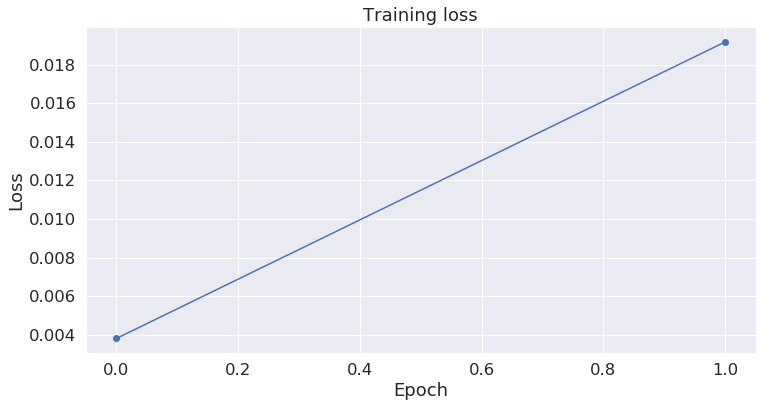

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [43]:
test = pd.read_csv("./data/blog_sample/blog_sample_data.tsv",delimiter="\t")
check = pd.read_excel("./doc-check.xlsx")
check = check[check["Daiva. Likely Propaganda? (0=N, 1=Y)"] == check["Scott Likely Propaganda? (0=N, 1=Y)"]]
test = test[test["story_id"].isin(check["ID"].unique())]
labels = [int(check[check["ID"]==story_id]["Daiva. Likely Propaganda? (0=N, 1=Y)"].values[0]) for story_id in test["story_id"].values]
test["label"] = labels

In [55]:
# Apply split function on the test data
test['text_split'] = test['raw_text'].apply(get_split)
test.head()

# create a row split version of dataset 

from tqdm import tqdm_notebook as tqdm
tmp = []

for i in tqdm(range(len(test))):
    for j in range(len(test.iloc[i].text_split)):
#         chunk_num = str(test.iloc[i]['story_id']) + '_' + str(j)
        chunk_num = j
        tmp.append(
        {'story_id': test.iloc[i]['story_id'],
            'chunk_num': chunk_num,
            'raw_text': test.iloc[i]['raw_text'],
            'text_chunk': test.iloc[i]['text_split'][j],
            'label': test.iloc[i].label}
        )

test_split_v = pd.DataFrame(tmp) 
# train.head()
print('length of test_split_v is:', len(test_split_v))
test_split_v.head()


length of test_split_v is: 94


,story_id,chunk_num,raw_text,text_chunk,label
0,96918,0,"kiev, ukraine -- in ukraine, just like in some...","kiev, ukraine -- in ukraine, just like in some...",0
1,96918,1,"kiev, ukraine -- in ukraine, just like in some...",the whole thing and attempt to prove that its ...,0
2,100591,0,"munich, germany -- defense leaders from europe...","munich, germany -- defense leaders from europe...",0
3,100591,1,"munich, germany -- defense leaders from europe...",greatest assets against the russian threat. in...,0
4,100591,2,"munich, germany -- defense leaders from europe...","strategic foreign policy objective, however.) ...",0


In [56]:
# Performance On Test Set
# Data preparation
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np


# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []


# For every sentence...
for text in test_split_v.text_chunk:
    
    # Report progress. 
    if ((len(test_input_ids) % 200) == 0):
        print('    Read {:,} comments.'.format(len(test_input_ids)))
        
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,       # Truncate all sentences 
                        truncation=True,
                   )
    # Add the method sentence to the list
    test_input_ids.append(encoded_sent)
    
print('DONE.')
print('')
print('{:>20,} test comments.'.format(len(test_input_ids)))


# Also retrieve the labels as a list:
# Get the labels from the Dataframe and convert from booleans to ints. 

test_labels = test_split_v['label'].to_numpy().astype(int)


print('{:>20,} labeled as 1'.format(np.sum(test_labels)))
print('{:>20,} labeled as 0'.format(len(test_labels) - np.sum(test_labels)))

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask) 

test_story_ids =test_split_v['story_id'].to_numpy().astype(int)
test_chunk_nums = test_split_v['chunk_num'].to_numpy().astype(int)


# Convert to tensors.
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
test_story_ids = torch.tensor(test_story_ids)
test_chunk_nums = torch.tensor(test_chunk_nums)

# Set the batch size.  
batch_size = 64  

# Create the DataLoader.
test_data = TensorDataset(test_inputs, test_masks, test_labels,test_story_ids,test_chunk_nums)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    Read 0 comments.
DONE.

                  94 test comments.
                  20 labeled as 1
                  74 labeled as 0


In [66]:
from torch.utils.data import Dataset, DataLoader

class PDataset(Dataset):
    def __init__(self,df):
        self.df = df
        self.story_ids = df["story_id"].unique()
        self.labels = np.array([df[df["story_id"] == id]["label"].values[0] for id in self.story_ids])
    def __len__(self):
        return len(self.story_ids)
    def __getitem__(self,id):
        story_id = self.story_ids[id]
        label = self.labels[id]
        text_chunks = self.df[self.df["story_id"]==story_id]["text_chunk"].values

        input_ids = []
        for text in text_chunks:
            encoded_sent = tokenizer.encode(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,       # Truncate all sentences 
                        truncation=True,
                   )
            input_ids.append(encoded_sent)
        
        input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
        
        return torch.tensor(input_ids), torch.tensor(label), torch.tensor(story_id)
        
dataset = PDataset(test_split_v)
dataloader = DataLoader(dataset, batch_size=1,shuffle=False)

In [67]:
import torch.nn as nn
from transformers import BertModel
from copy import deepcopy
state_dict = torch.load(model_path)

representation_model = BertModel.from_pretrained("bert-base-uncased",add_pooling_layer=True)
# model_state_dict = representation_model.state_dict()
new_state_dict = {}
for key in state_dict:
    if key == "classifier.weight" or key == "classifier.bias":
        continue
    model_key = ".".join(key.split(".")[1:])
    new_state_dict[model_key] = state_dict[key]
representation_model.load_state_dict(new_state_dict)

classifier_model = nn.Sequential(
    nn.Dropout(p=0.1),
    nn.Linear(768,2,bias=True)
)


new_state_dict = {}
for key in state_dict:
    if key == "classifier.weight" or key == "classifier.bias":
        model_key = "1." + key.split(".")[1]
        new_state_dict[model_key] = state_dict[key]

classifier_model.load_state_dict(new_state_dict)

representation_model.eval()
classifier_model.eval()
representation_model.to(device)
classifier_model.to(device)

Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=768, out_features=2, bias=True)
)

In [75]:
import torch.nn.functional as F
test_predictions, test_true_labels,story_ids = [], [], []

for step, (input_id, label,story_id) in enumerate(dataloader):
    input_id = input_id.view(-1,512).to(device)
    story_ids.append(story_id.squeeze().item())
    with torch.no_grad():
        representation = representation_model(input_id)[1]
        representation = torch.mean(representation,0).unsqueeze(0)
        classification = F.softmax(classifier_model(representation),1).squeeze()
        classification = torch.argmax(classification)
        test_predictions.append(int(classification.squeeze()))
        test_true_labels.append(int(label.squeeze()))

In [79]:
correct = 0
for i in range(len(test_predictions)):
    if test_predictions[i] == test_true_labels[i]:
        correct+=1
        print(test_predictions[i],test_true_labels[i], story_ids[i])

    # else:
        
print(correct/float(len(test_predictions)))

0 0 156241
0 0 278848
0 0 215921
0 0 92803
0 0 196448
0 0 142747
0 0 298285
0 0 168009
0 0 36593
0 0 153576
0 0 49258
1 1 73625
0 0 2469
0 0 48186
1 1 67202
1 1 78439
0 0 164532
0 0 54597
0 0 54961
0 0 205496
1 1 216983
0 0 201776
0 0 224413
0.5609756097560976


In [28]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()


# Tracking variables 
test_predictions, test_true_labels, test_story_ids, test_chunk_nums = [], [], [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0: 
        # calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress
        print('    Batch {:>5,}  of  {:>5,},      Elapsed: {:}.'.format(step, len(test_labels), elapsed))
        
        
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_story_ids, b_chunk_nums = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    story_ids = b_story_ids.to('cpu').numpy()
    chunk_nums = b_chunk_nums.to('cpu').numpy()
    # Store predictions and true labels
    
    test_predictions.append(logits)
    test_true_labels.append(label_ids)
    test_story_ids.append(story_ids)
    test_chunk_nums.append(chunk_nums)

print('    DONE.')

Predicting labels for 4,626 test sentences...
    DONE.


In [29]:
# Combine the results across the batches.
test_predictions = np.concatenate(test_predictions, axis=0)
test_true_labels = np.concatenate(test_true_labels, axis=0)
test_story_ids = np.concatenate(test_story_ids, axis=0)
test_chunk_nums = np.concatenate(test_chunk_nums, axis=0)

In [30]:
from tqdm import tqdm_notebook as tqdm
print('len(test_story_ids):',len(test_story_ids))
print('len(test_chunk_nums):', len(test_chunk_nums))
pred_label = np.argmax(test_predictions, axis=1).flatten()
test_result = []
for i in tqdm(range(len(test_true_labels))):
    test_result.append({'test_predictions':test_predictions[i],
                        'test_true_labels': test_true_labels[i],
                        'pred_label': pred_label[i],
                        'test_story_ids': test_story_ids[i],
                        'test_chunk_nums': test_chunk_nums[i]}
                        )
df_test_result = pd.DataFrame(test_result)
df_test_result.head()


len(test_story_ids): 4626
len(test_chunk_nums): 4626


,test_predictions,test_true_labels,pred_label,test_story_ids,test_chunk_nums
0,"[-5.0109434, 5.3030066]",1,1,35358787,0
1,"[-4.2002482, 4.3643236]",1,1,35358787,1
2,"[4.3625517, -4.6941648]",0,0,13312382,0
3,"[5.0458508, -5.4009237]",0,0,13312382,1
4,"[4.7697735, -5.136959]",0,0,35312144,0


In [32]:
# This part of the code takes care of the document level accuracy and list of misclassified articles at the document level

misclass_test_story_ids = df_test_result[df_test_result['test_true_labels']-df_test_result['pred_label'] !=0]['test_story_ids'].values.tolist()
misclass_test_story_ids = list(set(misclass_test_story_ids))
# print(misclass_test_story_ids)
# print(len(misclass_test_story_ids))

document_level_accuracy = 1- (len(misclass_test_story_ids)/len(test))
print('document_level_accuracy= ',document_level_accuracy)
# print('number of misclassified test documents= ', len(df_tmp))
print('number of test documents= ',len(test))

document_level_accuracy=  0.9747378455672069
number of test documents=  2098


In [ ]:
predictions[20:40]

In [ ]:
true_labels[20:40]

In [51]:
accuracy = flat_accuracy(test_predictions, test_true_labels)
print(accuracy)


0.9752765126870527
0.9752765126870527


In [40]:
# Our performance metric for the test set.
from sklearn.metrics import roc_auc_score

# Use the model output for label 1 as our prediction.
p1 = predictions[:,1]-predictions[:,0]

# Calculate the ROC AUC
auc = roc_auc_score(true_labels, p1)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.998


In [ ]:
!ls -l --block-size=K ./model_save/

In [36]:
# # Load a trained model and vocabulary that you have fine-tuned

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.load_state_dict(state_dict)
# tokenizer = tokenizer_class.from_pretrained(output_dir)

# # Copy the model to the GPU.
# model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [37]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [3]:
import pandas as pd

In [4]:
blog_data = pd.read_csv('./ukraine_blog_data.csv')

In [10]:
blog_data.columns

,blogsite_domain,count
270,respect-discussion.blogspot.com,35018
0,02varvara.wordpress.com,26870
379,www.stateofglobe.com,26618
226,nieuwsuitoekraine.blogspot.com,14806
23,aneritamtm.wordpress.com,13682
...,...,...
47,bristolroversmemorabilia.weebly.com,1
25,anthonyramienski.tumblr.com,1
245,patrickmurfin.livejournal.com,1
247,pennunion.weebly.com,1


In [11]:
import pandas as pd
ukraine_blog_data = pd.read_csv('./data/blog_sample/processed_ukraine_blog_data.csv')
bert_results = pd.read_csv('./code/ukraine-blog-results.csv')

In [12]:
merged_df = ukraine_blog_data.merge(bert_results,on='story_id')[["story_id","blogsite_domain","raw_text","bert_classification"]]
group_df = merged_df.groupby(['blogsite_domain','bert_classification']).size().reset_index(name="count")
pivot_df = group_df.pivot(index='blogsite_domain',columns='bert_classification',values='count')
pivot_df = pivot_df.rename_axis(None,axis=1)
pivot_df[0] = pivot_df[0].apply(lambda x: x if pd.notnull(x) else 0)
pivot_df[1] = pivot_df[1].apply(lambda x: x if pd.notnull(x) else 0)

In [4]:
import math
pivot_df["p_perc"] = round(pivot_df[1]/(pivot_df[0] + pivot_df[1]) * 100, 2)
pivot_df["np_perc"] = round(pivot_df[0]/(pivot_df[0] + pivot_df[1]) * 100, 2)
pivot_df["total"] = pivot_df[0] + pivot_df[1]

In [10]:
pivot_df.sort_values(by=['total'], ascending=False).reset_index()[["blogsite_domain","p_perc","np_perc","total"]].to_csv('blog_domain_p_np.csv',index=False)

In [43]:
merged_df[(merged_df["bert_classification"]==0)&(merged_df["blogsite_domain"]!="naturalnews.com")][["blogsite_domain","raw_text"]].sample(20).to_csv("sample_blog_np.csv")